In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [2]:
path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [3]:
scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT20&pLPT41'
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [72]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

In [73]:
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-12-08,Tweez scope,MC4100,pLPT20&pLPT41,aTc,10^(-5),2023_12_08


In [74]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')

In [75]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name)]# & 
        #(positions.Quality == 'Very good')]
df_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,Quality,exp length,Colonies,Centers,Radius,radj
0,2023-12-08,Tweez scope,0,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1,"515, 510",70.0,30.0
1,2023-12-08,Tweez scope,1,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1,"515, 510",100.0,20.0
2,2023-12-08,Tweez scope,2,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1,"510, 505",70.0,50.0
3,2023-12-08,Tweez scope,3,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Good,406,2,NaN,NaN,NaN
4,2023-12-08,Tweez scope,4,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1,"510, 510",100.0,50.0


In [76]:
poss = df_pos.Position.unique()
poss

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [77]:
#tincub = 289
poss.shape

(36,)

pos0


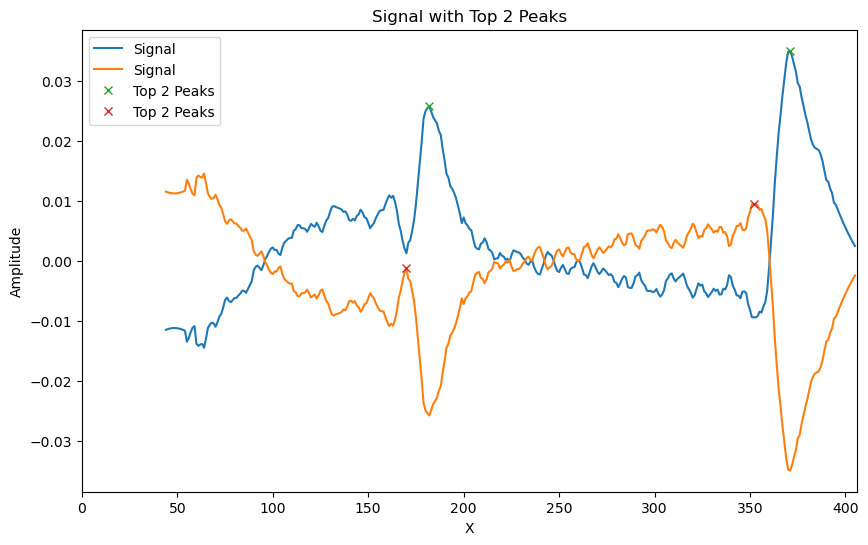

peaks1: [182 371]
peaks2: [170 352]
pos1


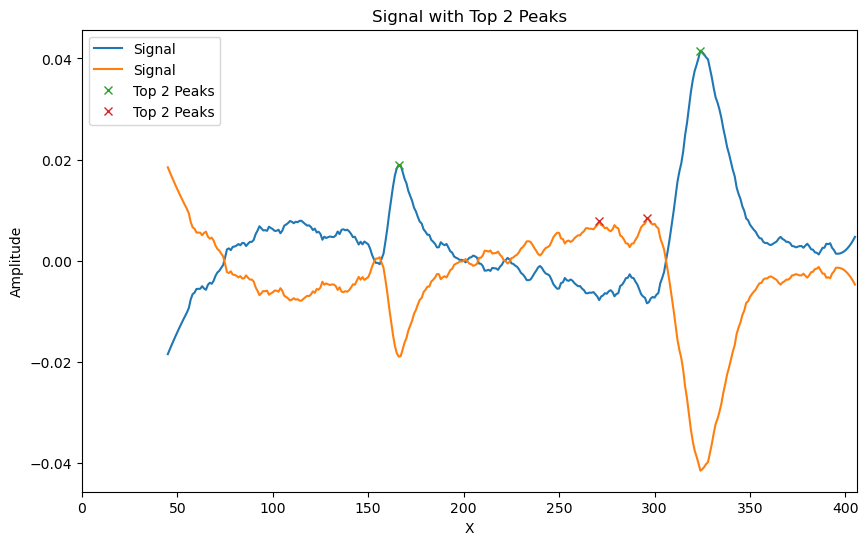

peaks1: [166 324]
peaks2: [271 296]
pos2


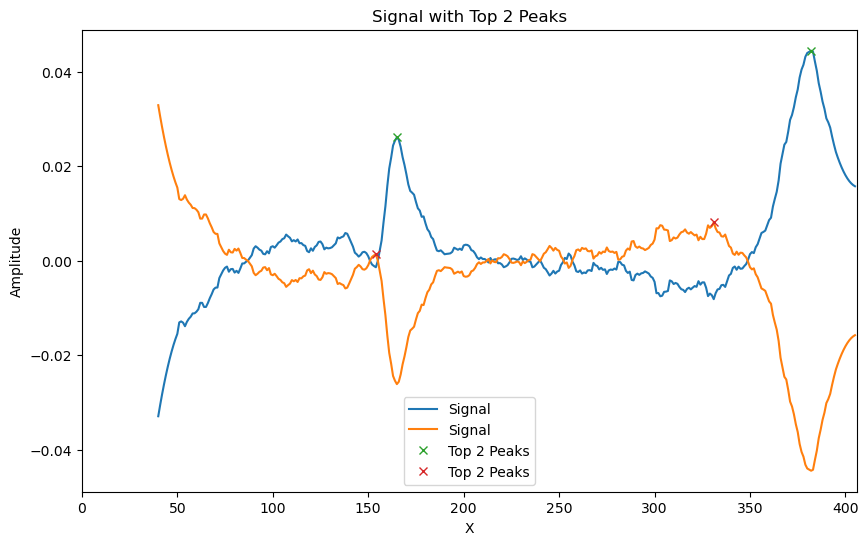

peaks1: [165 382]
peaks2: [154 331]
pos3


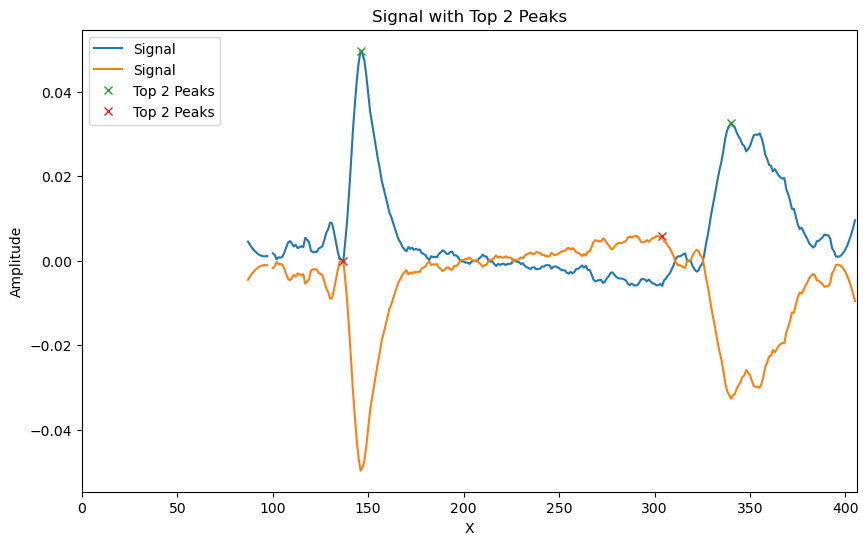

peaks1: [340 146]
peaks2: [137 304]
pos4


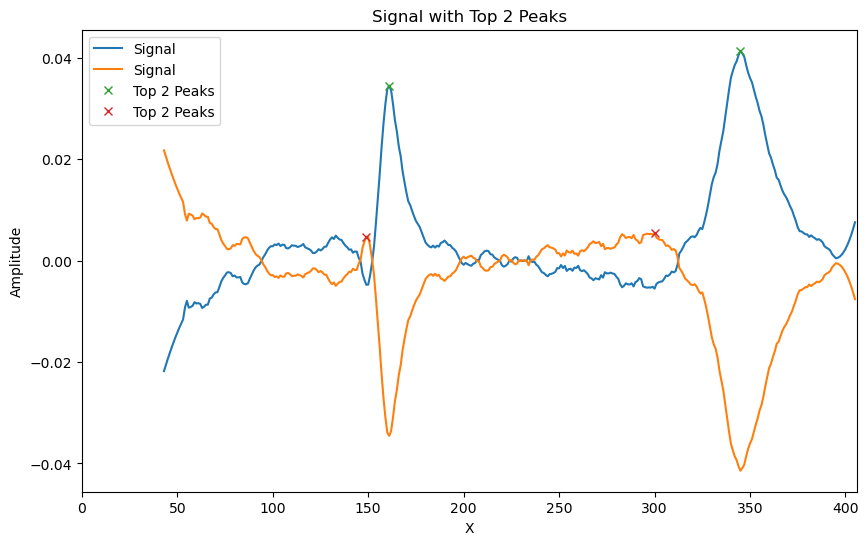

peaks1: [161 345]
peaks2: [149 300]
pos5


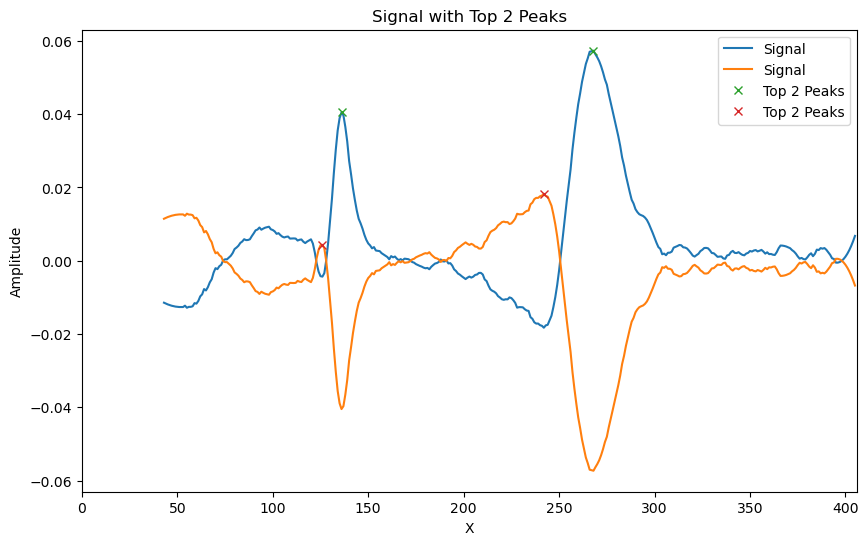

peaks1: [136 268]
peaks2: [126 242]
pos6


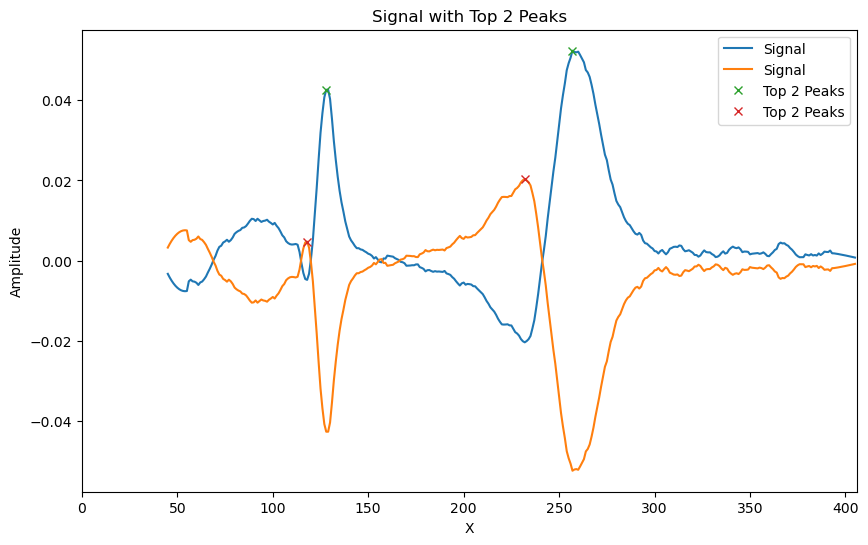

peaks1: [128 257]
peaks2: [118 232]
pos7


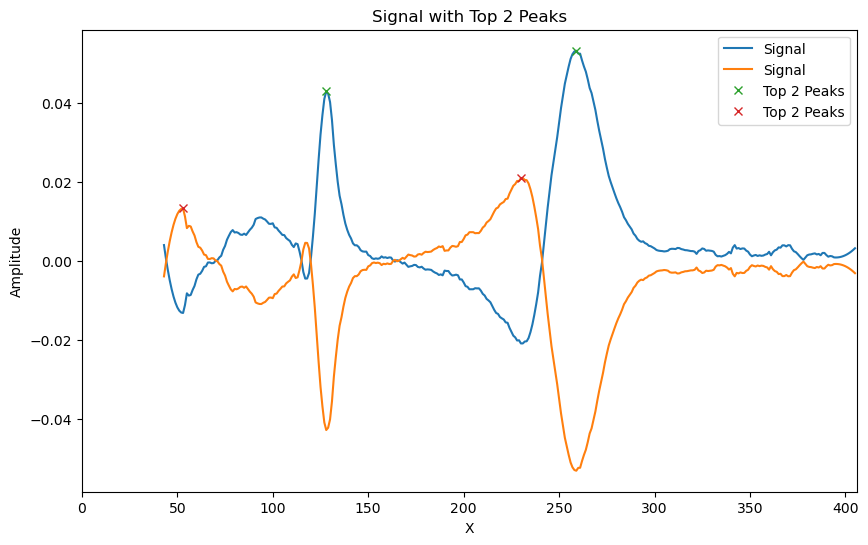

peaks1: [128 259]
peaks2: [ 53 230]
pos8


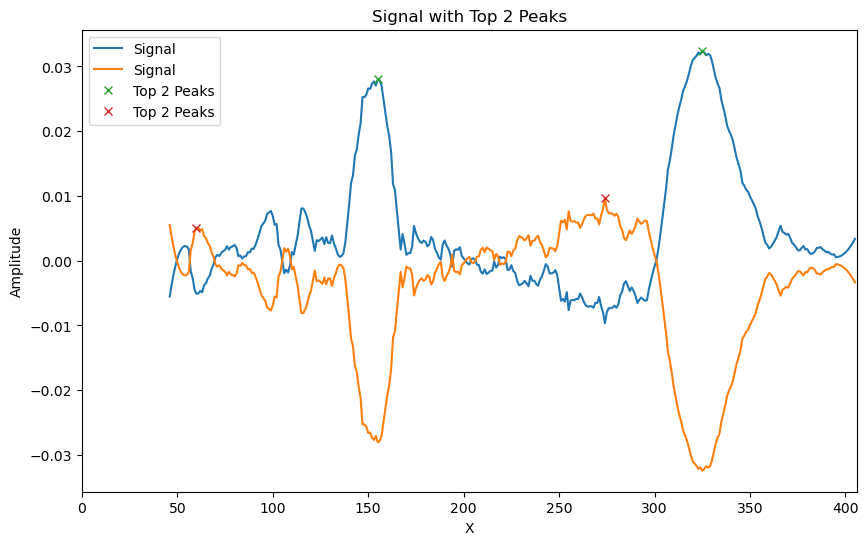

peaks1: [155 325]
peaks2: [ 60 274]
pos9


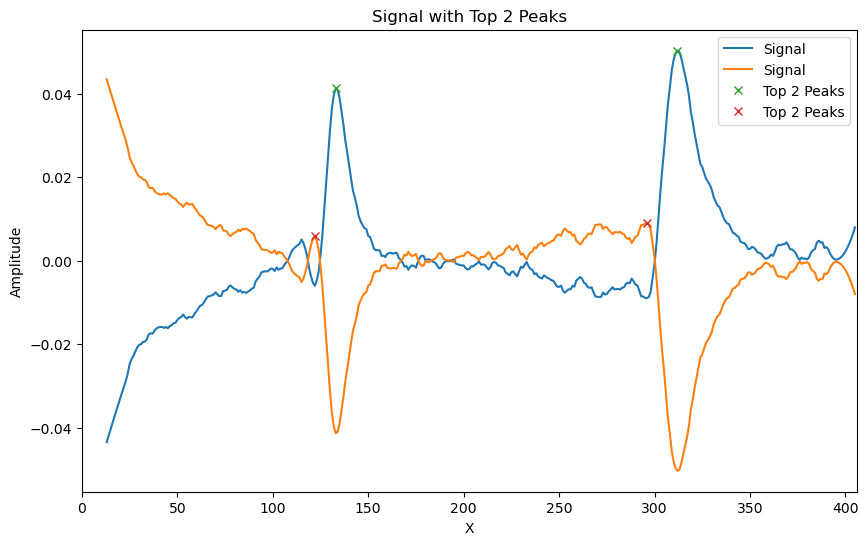

peaks1: [133 312]
peaks2: [122 296]
pos10


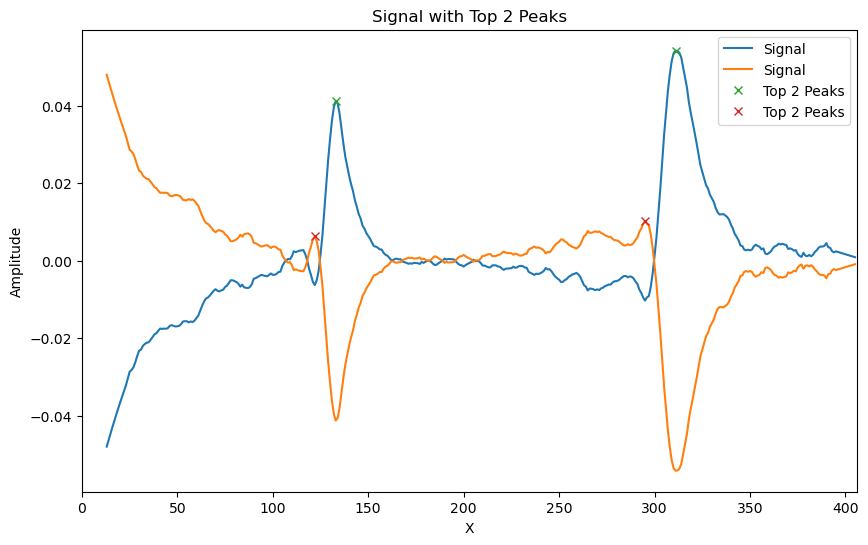

peaks1: [133 311]
peaks2: [122 295]
pos11


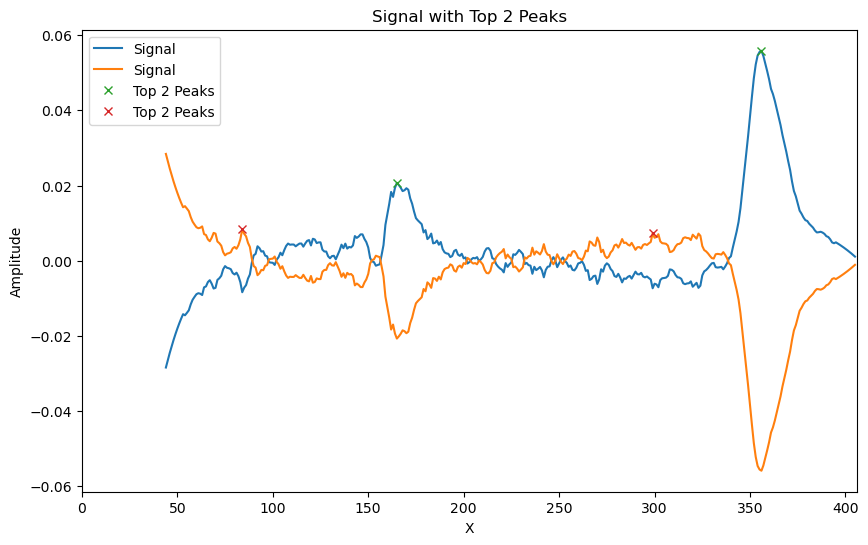

peaks1: [165 356]
peaks2: [299  84]
pos12


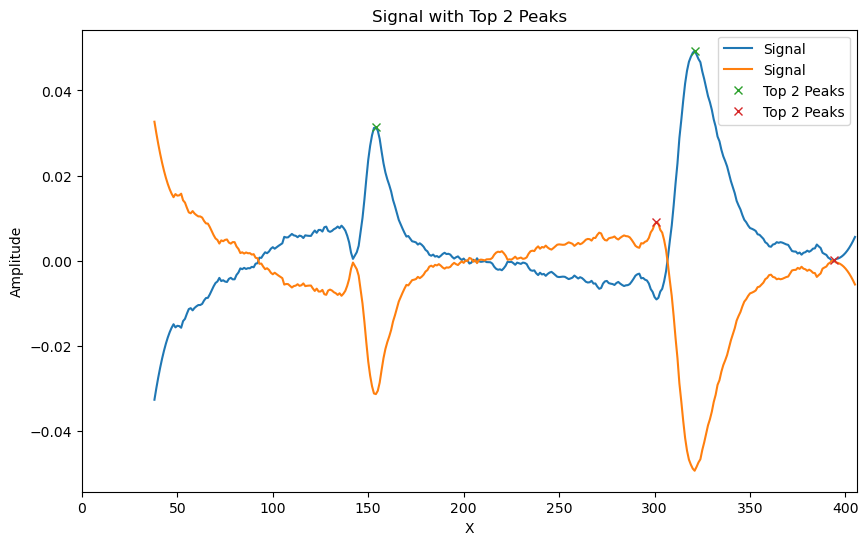

peaks1: [154 321]
peaks2: [394 301]
pos13


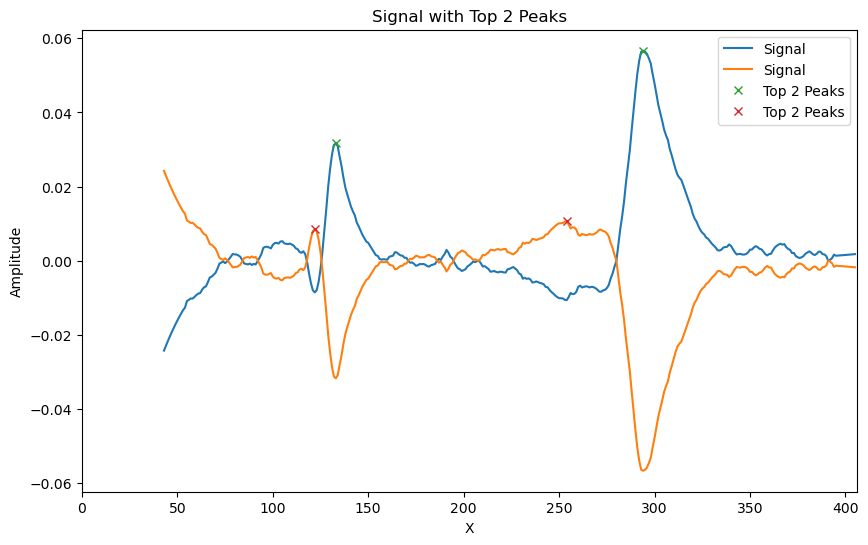

peaks1: [133 294]
peaks2: [122 254]
pos14


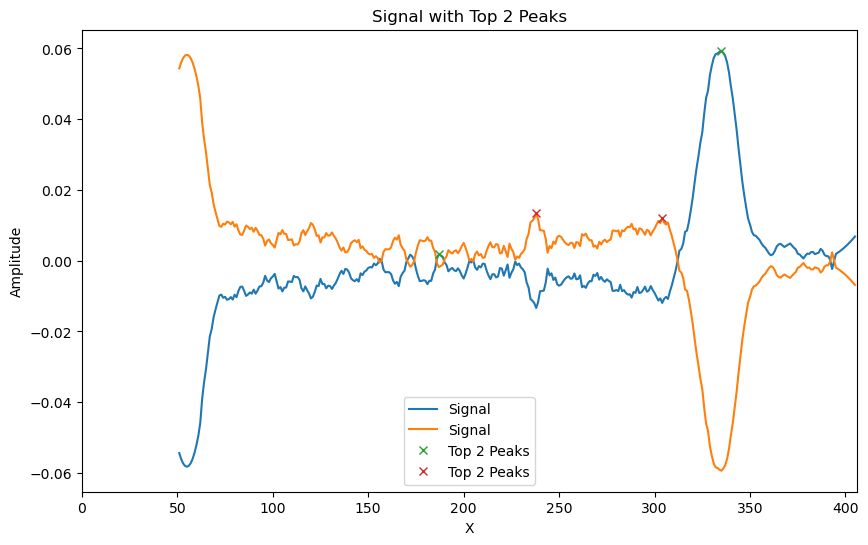

peaks1: [187 335]
peaks2: [304 238]
pos15


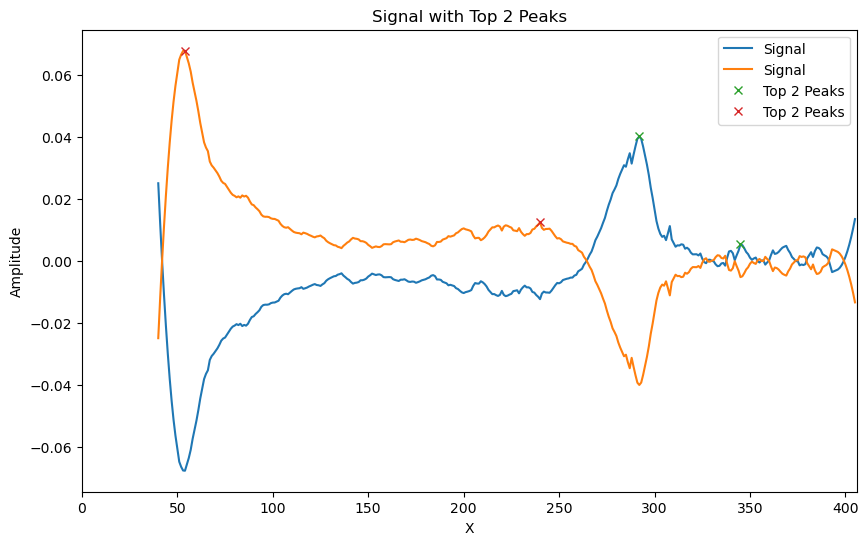

peaks1: [345 292]
peaks2: [240  54]
pos16


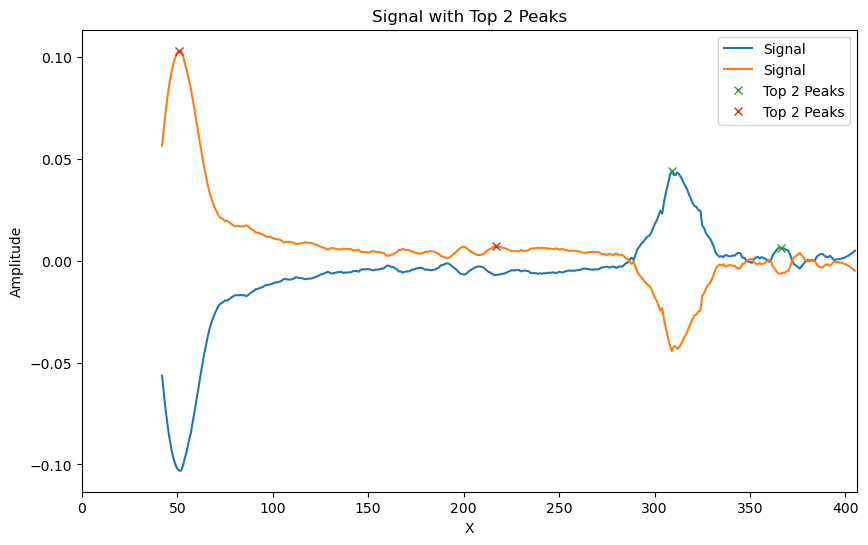

peaks1: [366 309]
peaks2: [217  51]
pos17


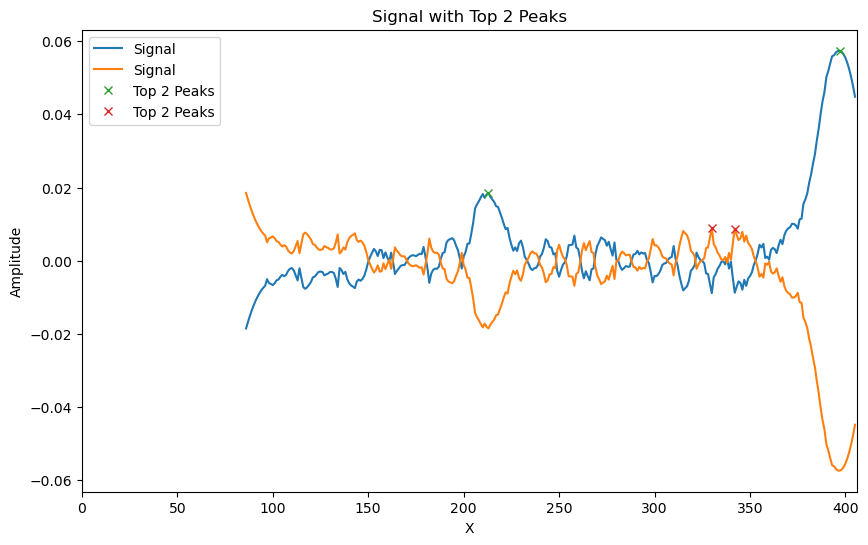

peaks1: [213 397]
peaks2: [342 330]
pos18


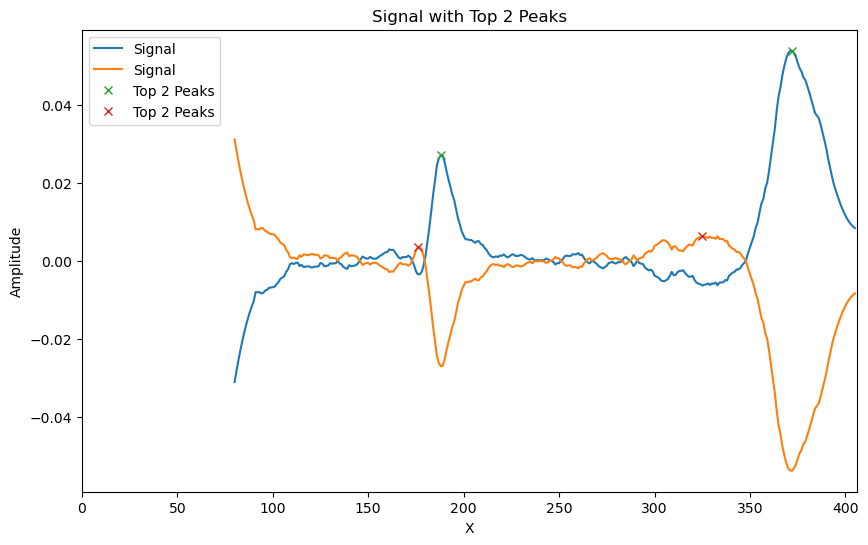

peaks1: [188 372]
peaks2: [176 325]
pos19


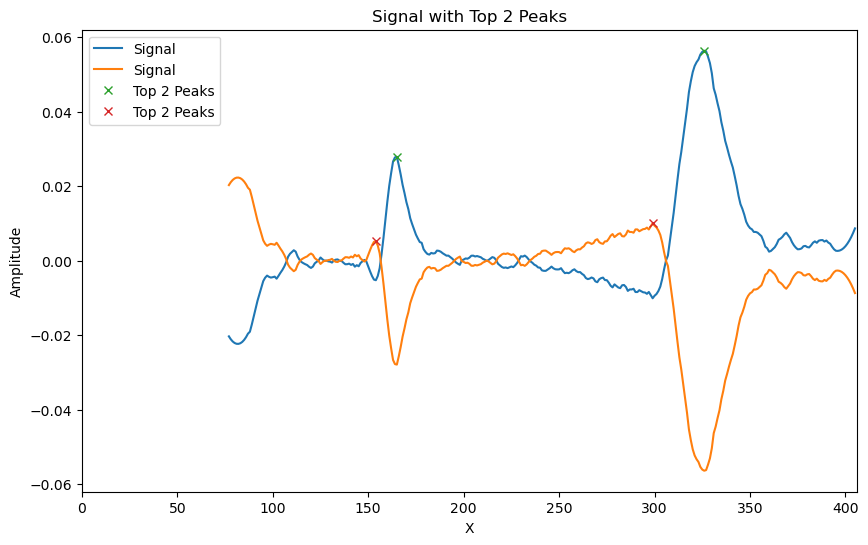

peaks1: [165 326]
peaks2: [154 299]
pos20


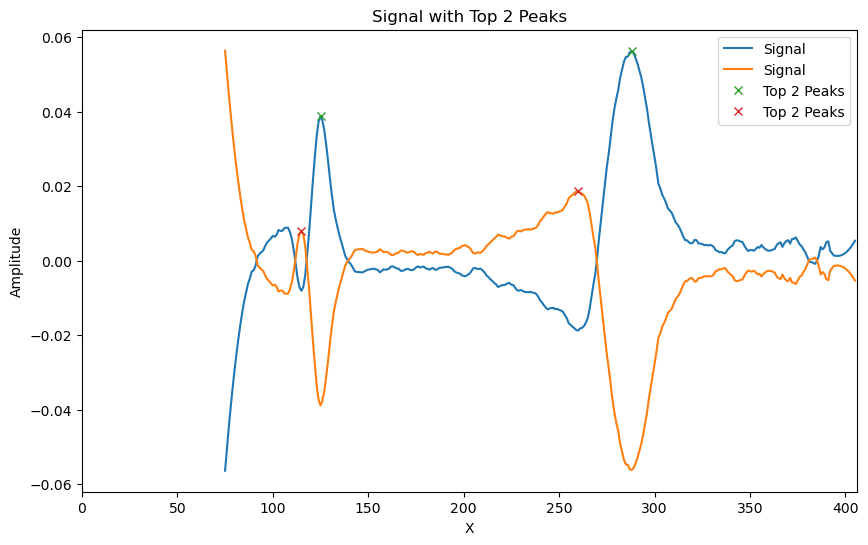

peaks1: [125 288]
peaks2: [115 260]
pos21


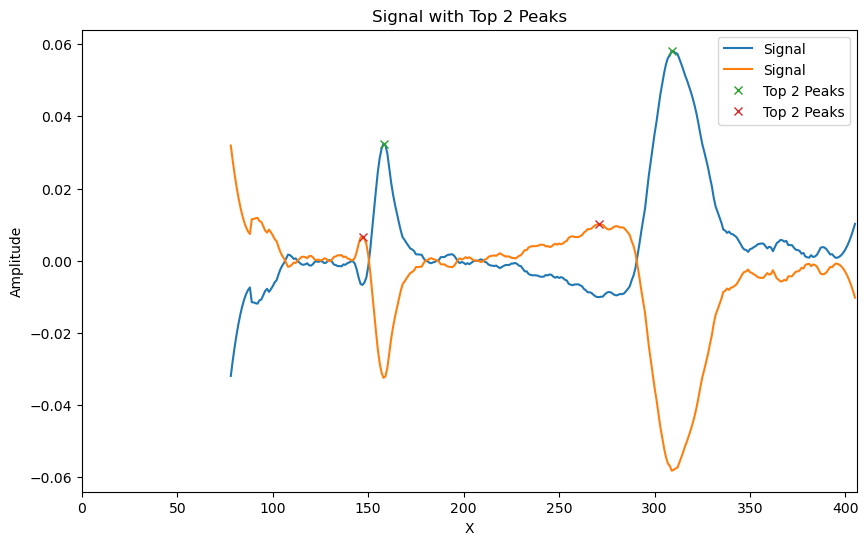

peaks1: [158 309]
peaks2: [147 271]
pos22


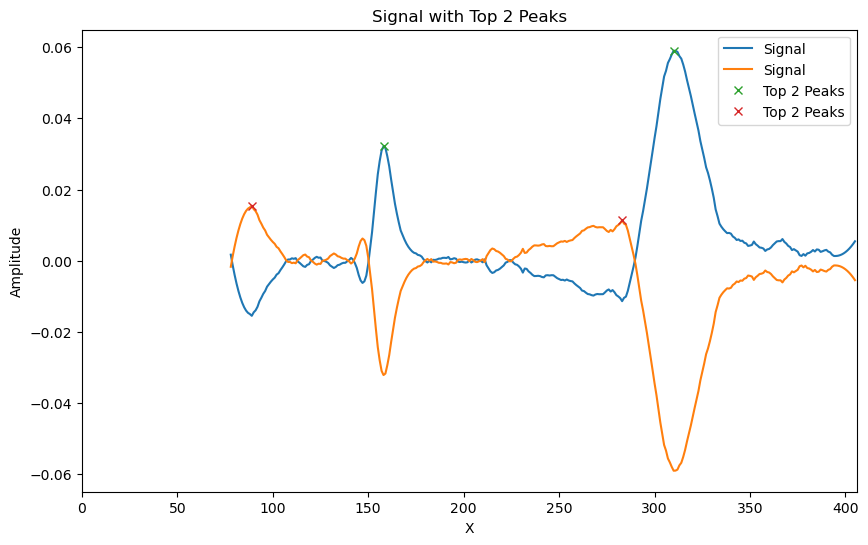

peaks1: [158 310]
peaks2: [283  89]
pos23


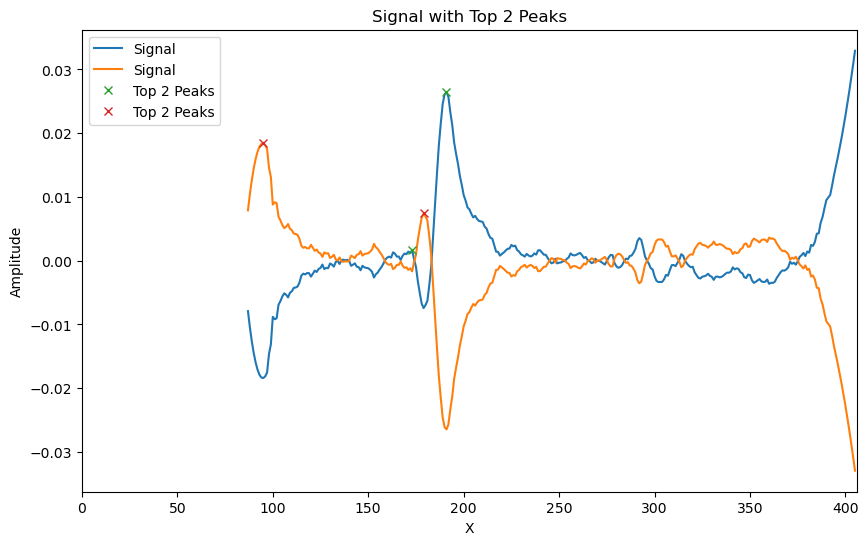

peaks1: [173 191]
peaks2: [179  95]
pos24


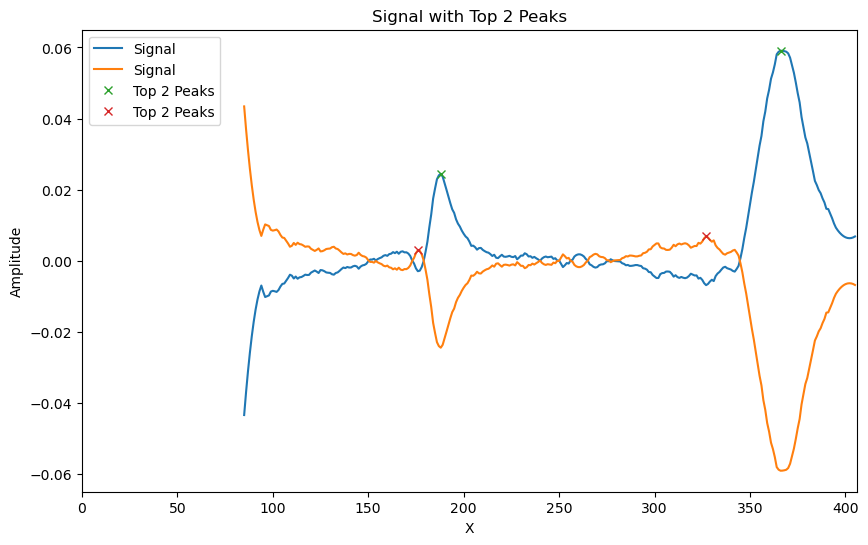

peaks1: [188 366]
peaks2: [176 327]
pos25


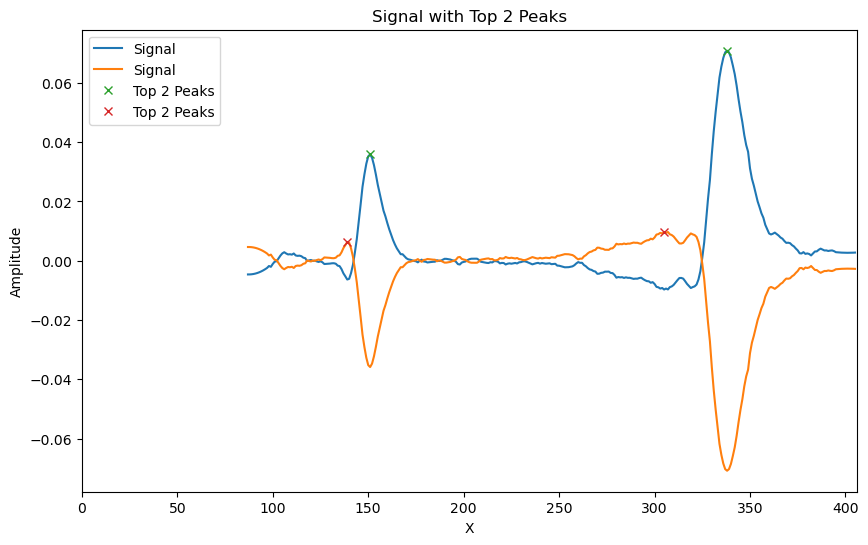

peaks1: [151 338]
peaks2: [139 305]
pos26


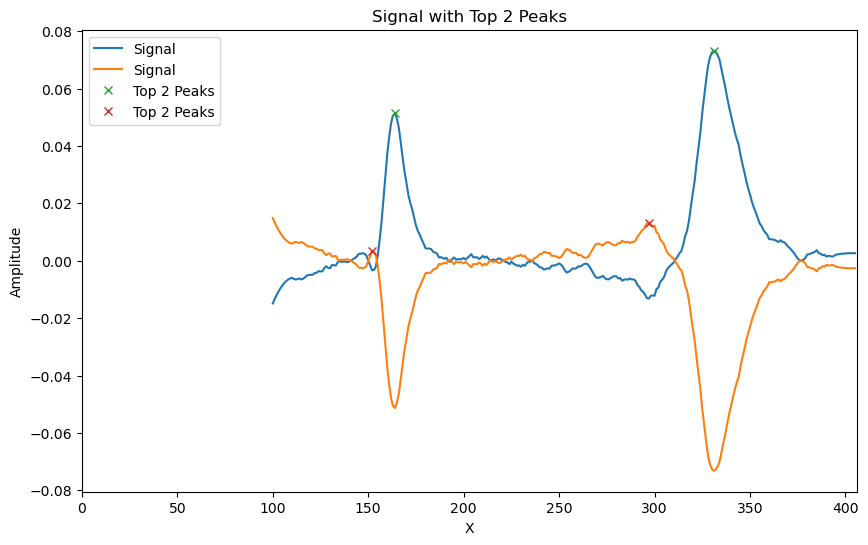

peaks1: [164 331]
peaks2: [152 297]
pos27


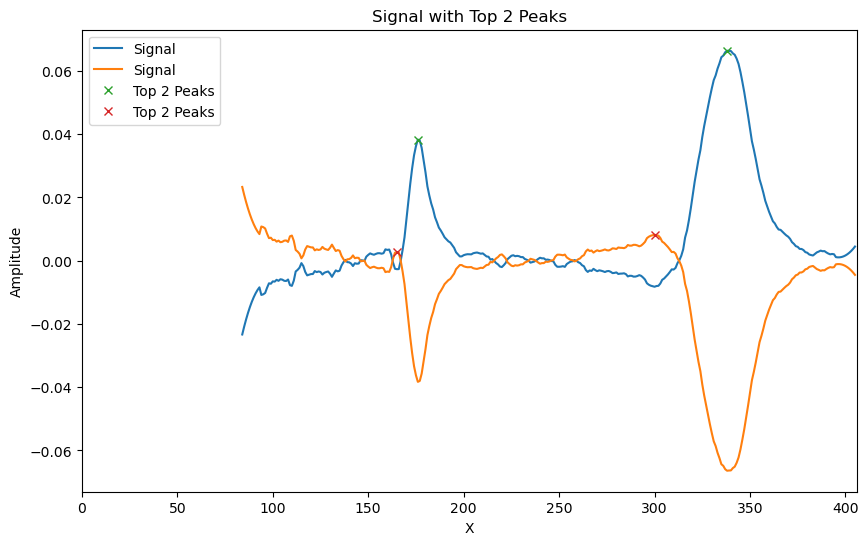

peaks1: [176 338]
peaks2: [165 300]
pos28


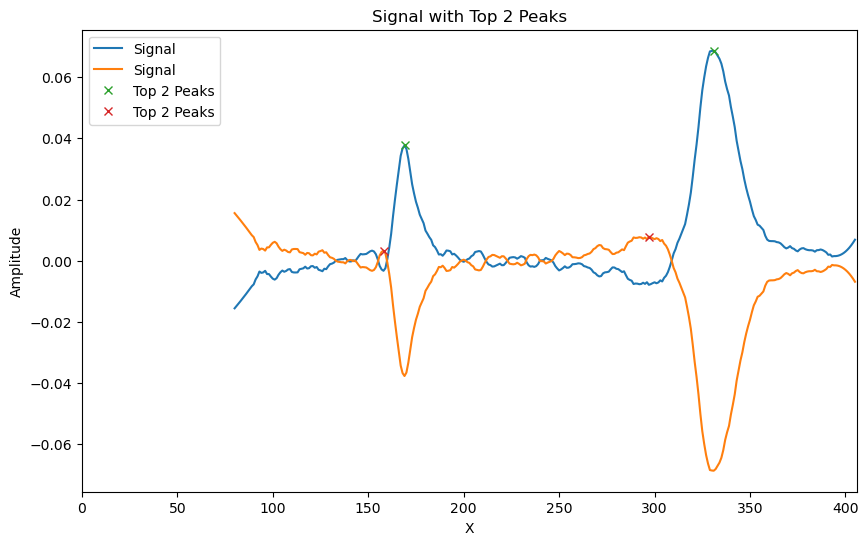

peaks1: [169 331]
peaks2: [158 297]
pos29


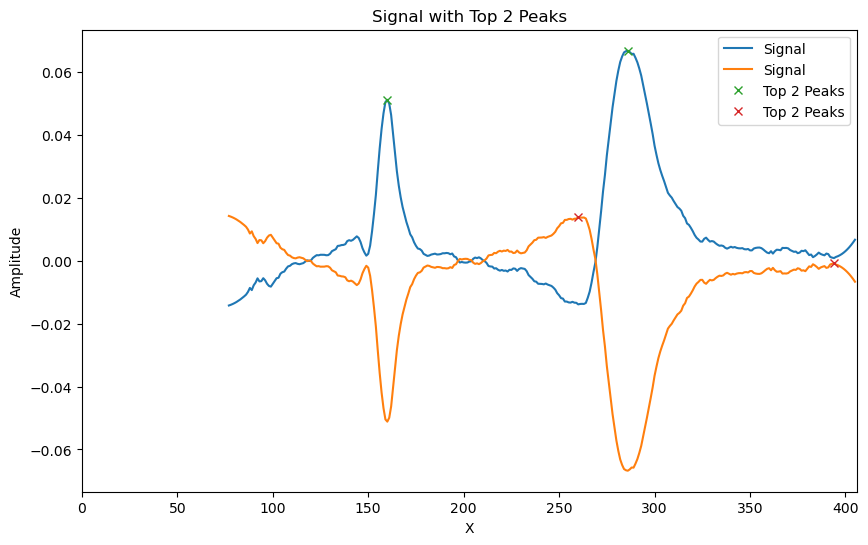

peaks1: [160 286]
peaks2: [394 260]
pos30


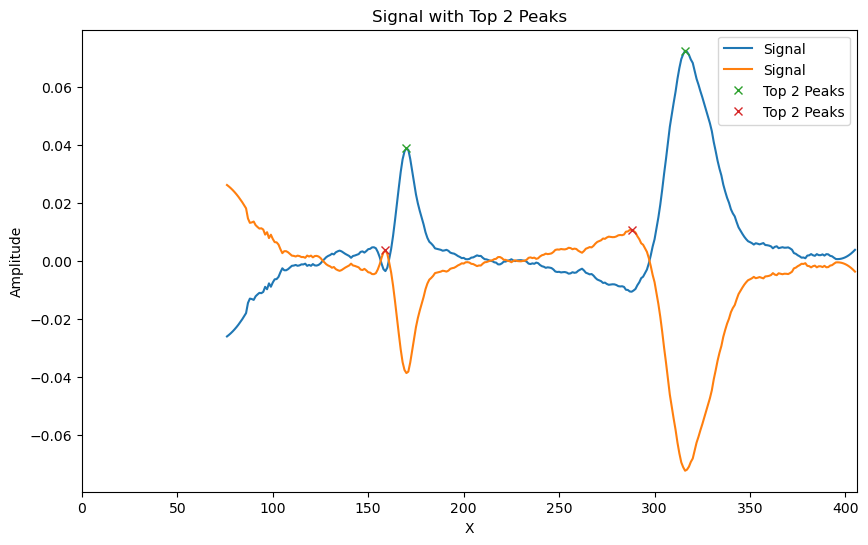

peaks1: [170 316]
peaks2: [159 288]
pos31


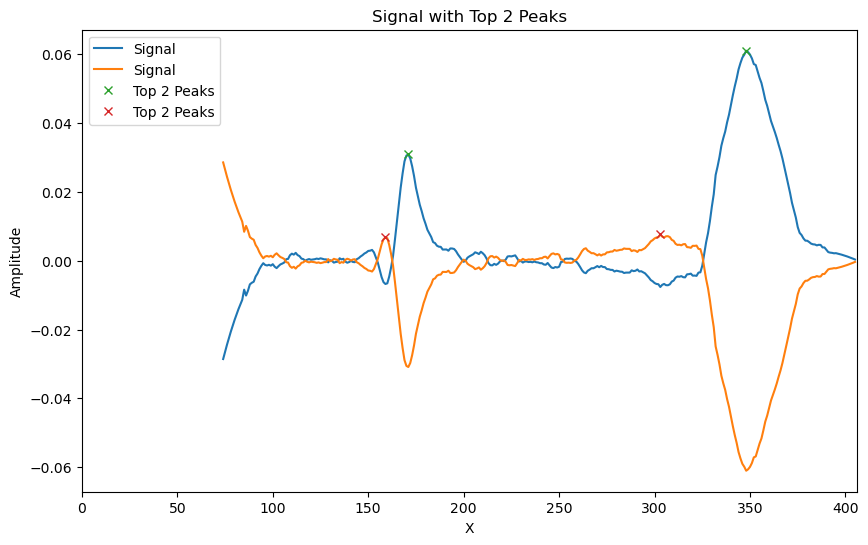

peaks1: [171 348]
peaks2: [159 303]
pos32


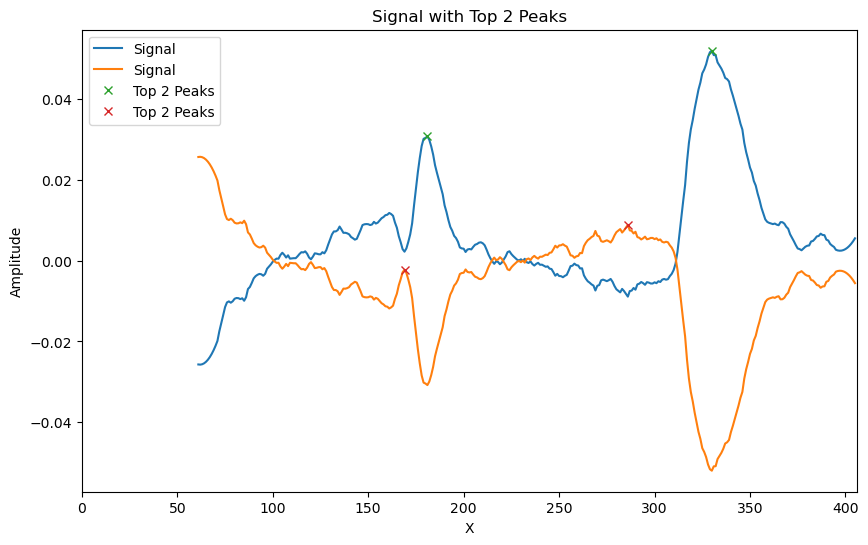

peaks1: [181 330]
peaks2: [169 286]
pos33


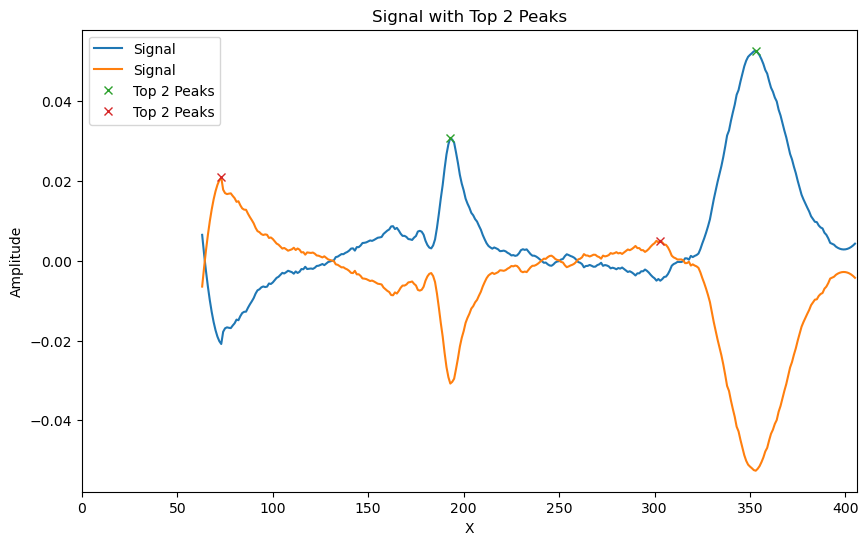

peaks1: [193 353]
peaks2: [303  73]
pos34


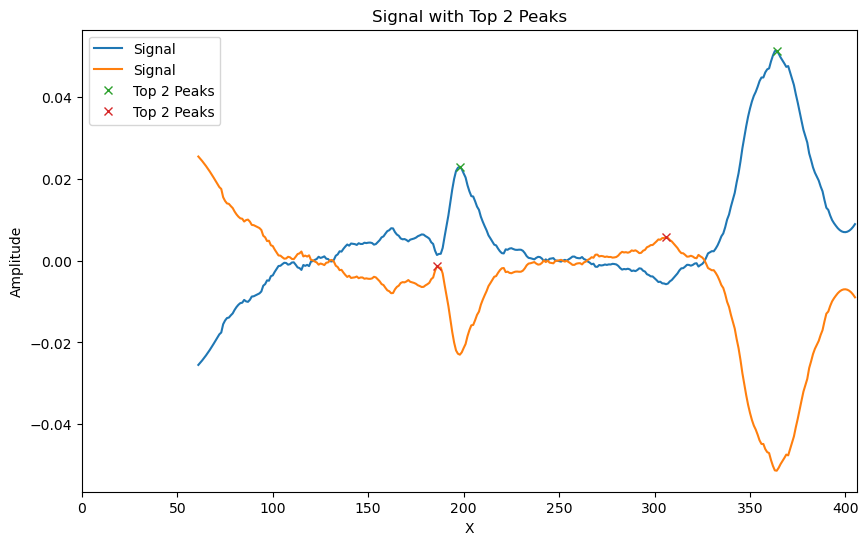

peaks1: [198 364]
peaks2: [186 306]
pos35


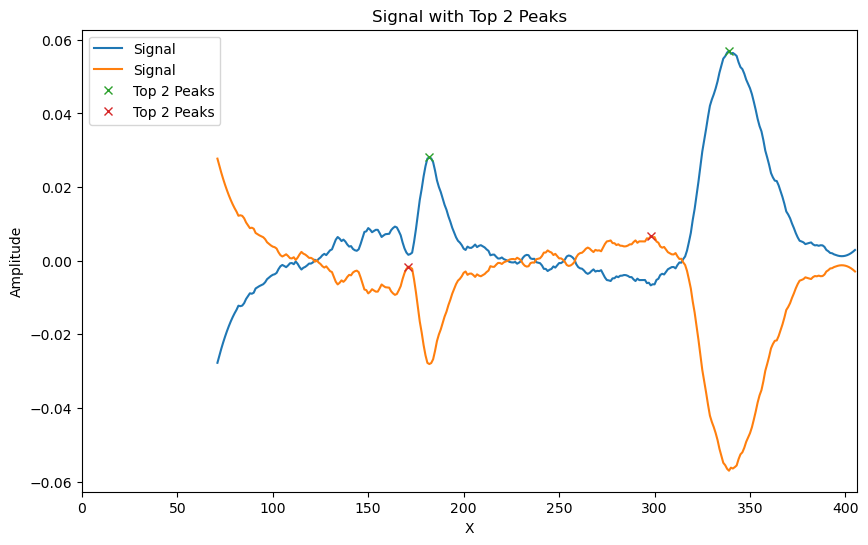

peaks1: [182 339]
peaks2: [171 298]


In [78]:
wave_arr = np.zeros((36,2))
dlrhos_center = np.zeros((36, 406, 2))
for i, pos in enumerate(poss):
#wave_arr = np.zeros((3,4))
#dlrhos_center = np.zeros((3, 406, 2))
#for i, pos in enumerate([14,15,16]):
    print(f"pos{i}")
    dlrhos_center[i,:,:] = np.load(os.path.join(path_ext,scope_name,exp_date,folder_results,f"pos{pos}", 'dlrho_center.npy'))
    dlrhos = dlrhos_center[i,:,:]
    t = np.arange(406)
    signal = dlrhos
    peaks, properties = find_peaks(dlrhos[:,0], height=-0.04, prominence=0.005)  # Adjust parameters based on your signal
    
    sorted_indices = np.argsort(properties['peak_heights'])[-2:]  # Get indices of the top 2 peaks by height
    top_peaks = peaks[sorted_indices]

    
    peaks1, properties1 = find_peaks(dlrhos[:,1], height=-0.04, prominence=0.005)  # Adjust parameters based on your signal
    sorted_indices1 = np.argsort(properties1['peak_heights'])[-2:]  # Get indices of the top 2 peaks by height
    top_peaks1 = peaks1[sorted_indices1]
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, dlrhos, label='Signal')
    plt.plot(t[top_peaks], dlrhos[top_peaks,0], "x", label='Top 2 Peaks')
    plt.plot(t[top_peaks1], dlrhos[top_peaks1,1], "x", label='Top 2 Peaks')
    plt.title('Signal with Top 2 Peaks')
    plt.xlabel('X')
    plt.ylabel('Amplitude')
    plt.xlim([0,406])
    plt.legend()
    plt.show()
    print(f"peaks1: {t[top_peaks]}")
    print(f"peaks2: {t[top_peaks1]}")
    wave_arr[pos,:] = t[top_peaks]
    #wave_arr[i,:] = t[top_peaks]

In [79]:
wave_arr

array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [340., 146.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
       [133., 294.],
       [187., 335.],
       [345., 292.],
       [366., 309.],
       [213., 397.],
       [188., 372.],
       [165., 326.],
       [125., 288.],
       [158., 309.],
       [158., 310.],
       [173., 191.],
       [188., 366.],
       [151., 338.],
       [164., 331.],
       [176., 338.],
       [169., 331.],
       [160., 286.],
       [170., 316.],
       [171., 348.],
       [181., 330.],
       [193., 353.],
       [198., 364.],
       [182., 339.]])

In [81]:
wave_arr = np.array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [146., 340.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
       [133., 294.],
       [55., 335.],
       [54., 292.],
       [51., 309.],
       [213., 397.],
       [188., 372.],
       [165., 326.],
       [125., 288.],
       [158., 309.],
       [158., 310.],
       [95., 191.],
       [188., 366.],
       [151., 338.],
       [164., 331.],
       [176., 338.],
       [169., 331.],
       [160., 286.],
       [170., 316.],
       [171., 348.],
       [181., 330.],
       [193., 353.],
       [198., 364.],
       [182., 339.]])

In [82]:
wave_arr

array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [146., 340.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
       [133., 294.],
       [ 55., 335.],
       [ 54., 292.],
       [ 51., 309.],
       [213., 397.],
       [188., 372.],
       [165., 326.],
       [125., 288.],
       [158., 309.],
       [158., 310.],
       [ 95., 191.],
       [188., 366.],
       [151., 338.],
       [164., 331.],
       [176., 338.],
       [169., 331.],
       [160., 286.],
       [170., 316.],
       [171., 348.],
       [181., 330.],
       [193., 353.],
       [198., 364.],
       [182., 339.]])

In [15]:
dlrhos.shape

(406, 2)

In [14]:
wave_arr

array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [340., 146.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
       [133., 294.],
       [187., 335.],
       [345., 292.],
       [366., 309.],
       [213., 397.],
       [188., 372.],
       [165., 326.],
       [125., 288.],
       [158., 309.],
       [158., 310.],
       [173., 191.],
       [188., 366.],
       [151., 338.],
       [164., 331.],
       [176., 338.],
       [169., 331.],
       [160., 286.],
       [170., 316.],
       [171., 348.],
       [181., 330.],
       [193., 353.],
       [198., 364.],
       [182., 339.]])

In [16]:
poss = [14,15,16]

In [19]:
nt,nc = 406, 3
npos = 3
mean = np.zeros((npos,nt,nc))
rho = np.zeros((npos,nt,nc-1))
lrho = np.zeros((npos,nt,nc-1))
dlrho = np.zeros_like(lrho) + np.nan

In [42]:
for i, pos in enumerate([15]):#poss:
    print(f"Pos {pos}")
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    print(fname)
    path_im = os.path.join(path, fname)
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    im_all = imread(path_im)
    im_all = im_all[:,:,:,:ph_chn]
    nt,nx,ny,nc = im_all.shape    
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    edt = np.load(os.path.join(path_results,'edt.npy'))
    edt = edt[:,:,:]

    bg = np.zeros((nc,))
    for c in range(nc):
        bg[c] = im_all[0,:100,:100,c].mean()
    
    mean = np.zeros((nt,nc))
    rho = np.zeros((nt,2))
    lrho = np.zeros((nt,2))
    dlrho = np.zeros_like(lrho) + np.nan
    rw = 16
    Rmax = edt.max()

    for t in range(nt):    
        tedt = edt[t,:,:]
        idx = tedt > Rmax - rw        
        if np.sum(idx)>0:
            if fluo_chns == 3:
                ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
                ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
                x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
                mean[t,rfp_chn] = x.mean()
                mean[t,yfp_chn] = y.mean()
                mean[t,cfp_chn] = z.mean()            
            elif fluo_chns == 2:                
                ntim0 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim1 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]               
                x,y = ntim0[idx], ntim1[idx]
                mean[t,yfp_chn] = x.mean()
                mean[t,cfp_chn] = y.mean()
    if fluo_chns == 3:
        rho[:,0] = mean[:,0] / mean[:,2]
        rho[:,1] = mean[:,1] / mean[:,2]
        lrho = np.log(rho)
        for c in range(2):
            idx = ~np.isnan(lrho[:,c])
            dlrho[idx,c] = savgol_filter(lrho[idx,c], 21, 3, deriv=1, axis=0) 
    elif fluo_chns == 2:
        rho[:,0] = mean[:,0] / mean[:,1]
        rho[:,1] = mean[:,1] / mean[:,0]
        lrho = np.log(rho)
    for c in range(2):
        idx = ~np.isnan(lrho[:,c])
        dlrho[idx,c] = savgol_filter(lrho[idx,c], 21, 3, deriv=1, axis=0)

    #np.save(os.path.join(path_results, 'dlrho_center.npy'), dlrho)

Pos 15
2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos15.ome.tif


/tmp/ipykernel_1489627/972129413.py:51: RuntimeWarning: invalid value encountered in divide
  rho[:,0] = mean[:,0] / mean[:,1]
/tmp/ipykernel_1489627/972129413.py:52: RuntimeWarning: invalid value encountered in divide
  rho[:,1] = mean[:,1] / mean[:,0]


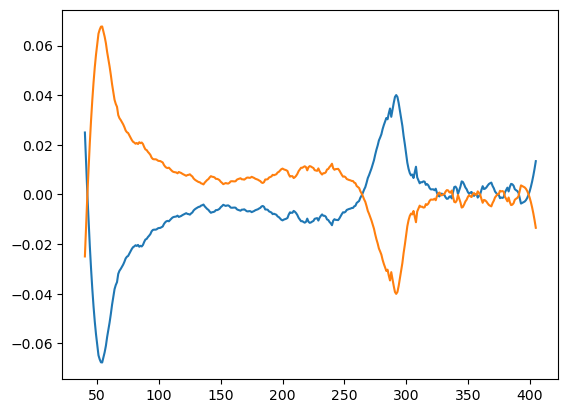

In [45]:
plt.plot(dlrho)
plt.show()

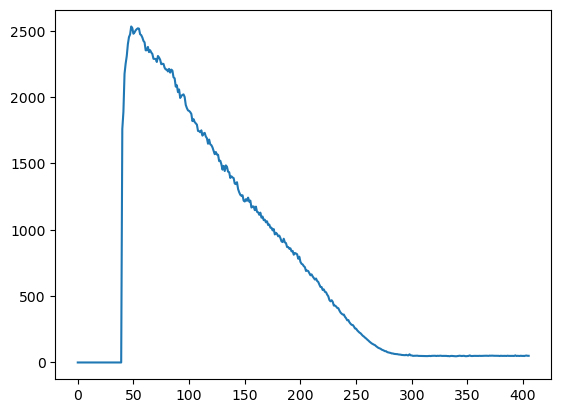

In [43]:
plt.plot(mean[:,0])
plt.show()

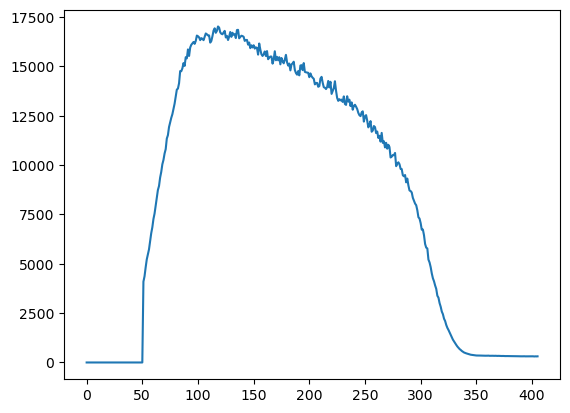

In [41]:
plt.plot(mean[:,1])
plt.show()

In [ ]:
wave_arr = array([[182., 371.],
       [166., 324.],
       [165., 382.],
       [146., 340.],
       [161., 345.],
       [136., 268.],
       [128., 257.],
       [128., 259.],
       [155., 325.],
       [133., 312.],
       [133., 311.],
       [165., 356.],
       [154., 321.],
#14    [55., 294.],
       [187., 335.],
       [345., 292.],
       [366., 309.],
       [213., 397.],
       [188., 372.],
       [165., 326.],
       [125., 288.],
       [158., 309.],
       [158., 310.],
       [173., 191.],
       [188., 366.],
       [151., 338.],
       [164., 331.],
       [176., 338.],
       [169., 331.],
       [160., 286.],
       [170., 316.],
       [171., 348.],
       [181., 330.],
       [193., 353.],
       [198., 364.],
       [182., 339.]])